In [209]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [210]:
train = pn.read_csv('train.csv')
test = pn.read_csv('test.csv')
example = pn.read_csv('gender_submission.csv')

number_f = train.select_dtypes(exclude='object').columns
cateforical_f = train.select_dtypes(include='object').columns

In [211]:
train.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [212]:
def preprocessing(df):
    df = df.copy()

    def name(s: str):
      pattern = r',\s*([^\.]+)\.'

      new_s = re.search(pattern, s).group(1).strip()
      if new_s in ('Master', 'Miss', 'Mr', 'Mrs'): return new_s
      else: return 'Other'

    df = df.drop(['Cabin', 'Ticket', 'Embarked'], axis=1) # слишком много пропусков, 687/891, то есть 77%

    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Name'] = df['Name'].apply(name)
    df['Age'] = df['Age'].fillna(df['Age'].median())

    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    return df

pre_train = preprocessing(train)

<h4>Можно сделать вывод, что статус человек вполне сильно взаимосвязан с шансом выживания.</h4>

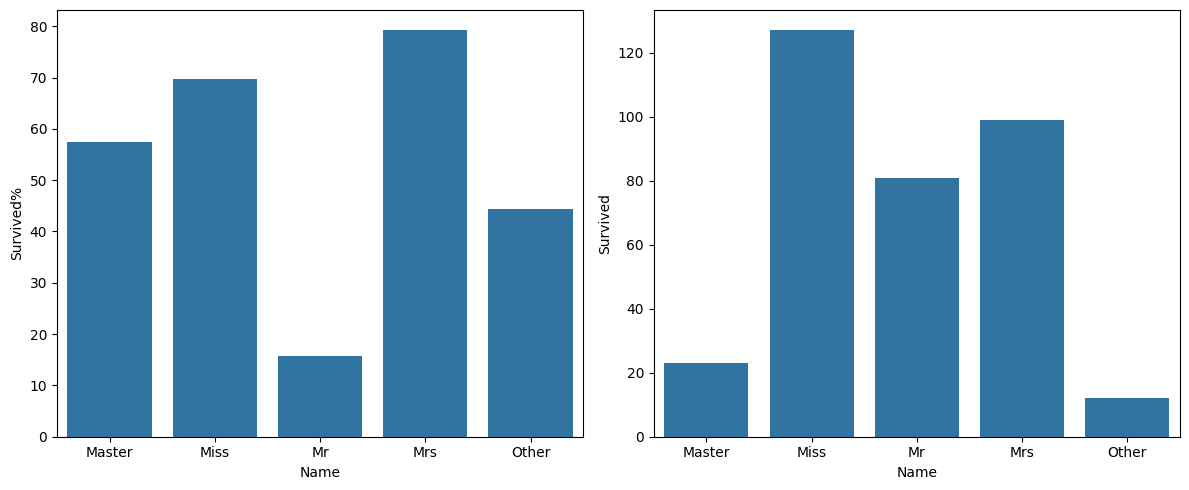

In [213]:
stats = pre_train.groupby('Name')['Survived'].agg([('Total', 'count'), ('Survived', 'sum')])
stats['Survived%'] = stats['Survived']/stats['Total'] * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=stats.index, y='Survived%', data=stats, ax=axes[0])
sns.barplot(x=stats.index, y='Survived', data=stats, ax=axes[1])

plt.tight_layout()
plt.show()

<h4>Обработка средним по отклику показало лучший резуьтат, чем в прошлый.</h4>

In [214]:
d = {}
for i in pre_train['Name'].unique():
    n_1 = pre_train[(pre_train['Name'] == i) & (pre_train['Survived'] == 1)].shape[0]
    n_0 = pre_train[(pre_train['Name'] == i) & (pre_train['Survived'] == 0)].shape[0]
    d[i] = n_1 / (n_1 + n_0)
pre_train['Name'] = pre_train['Name'].map(d)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(pre_train.drop(['PassengerId', 'Survived'], axis=1), pre_train['Survived'], test_size=0.3, random_state=42)

In [216]:
grid = {'n_estimators': [10, 50, 100, 200, 500, 1000], 'max_depth': [3, 5, 7]}

model = GridSearchCV(RandomForestClassifier(), grid, cv=5, scoring='accuracy')
model.fit(X_train, y_train)

print(model.best_params_)
print(model.best_score_) # 0.7977

{'max_depth': 5, 'n_estimators': 500}
0.8298451612903227


In [217]:
model = RandomForestClassifier(max_depth=5, n_estimators=500)
X = pn.concat([X_train, X_test], axis=0).sort_index()
y = pn.concat([y_train, y_test], axis=0).sort_index()
model.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [218]:
pre_test = preprocessing(test)
pre_test['Name'] = pre_test['Name'].map(d)

y_pred = model.predict(pre_test.drop('PassengerId', axis=1))

In [219]:
out = pn.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred})
out.to_csv('final.csv', index=False)
out

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
